Status: ✅ done

## Exercise 8

---

In this exercise, we dive deep into `decision theory`, therefore it is okay if this exercise feels harder than usual, it is supposed to. 🙃 

> Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

### Quick recap

---

> Theoretical recap on probability

In this exercise, I will assume that you are familiar with fundamental concepts of probability theory. Here, I refresh them for you. (feel free to skip if you feel confident in it).

Essentially, it all starts with a `joint distribution` of data $p(x, y)$. (for simplicity here just for two random variables but the same applies to $n$ random variables) If you have joint distribution, you can infer all other terms as follows:

**Marginal distribution**

For `discrete` random variables X and Y, we can write the following expression:

$
\begin{aligned}
p(x) = \sum_y p(x, y) \\
p(y) = \sum_x p(x, y)
\end{aligned}
$

In words, to get for instance $p(x)$, we keep $x$ constant and iterate over all $y$.

For `continuous` random variables X and Y, we can write the following expression:

$
\begin{aligned}
f(x) = \int_y f(x, y) \\
f(y) = \int_x f(x, y)
\end{aligned}
$

**Conditional distribution**
For `discrete` random variables X and Y, we can write the following expression:

$
\begin{aligned}
p(x | y) = \frac{p(x, y)}{p(y)} \\
p(y | x) = \frac{p(x, y)}{p(x)}
\end{aligned}
$

For `continuous` random variables X and Y, we can write the following expression:

$
\begin{aligned}
f(x | y) = \frac{f(x, y)}{f(y)} \\
f(y | x) = \frac{f(x, y)}{f(x)}
\end{aligned}
$

**Note on the ml lingo**
Below, you will often see me using the following three terms:

- `posterior probability`: $p(y | x)$ (a.k.a. probability of $y$ given $x$ - note the subword 'post')

- `class conditional probability`: $p(x | y)$ (a.k.a. probability of $x$ given $y$)

- `class priors`: $p(y)$

In the case of `generative models`, the class conditional and prior are **explicitly** estimated in order to get the class posterior probability for each respective class. In the case of `discriminative` models, we model the posterior probability directly and the class conditional and prior are estimated **implicitly** (the probabilities are embedded in the model itself but we do not have access to it). 

> Practical recap on probability

Enough of theory, let's try to apply these concepts to the dataset from the previous exercise. Note that since this dataset is only a sample from a true population, the probabilities that we get are only estimates of the true values. Nevertheless, it still demonstrates the working of the above fomrulas. First, we need to load the data:

In [2]:
# Load training data
training = pd.read_csv("Ex1-training.csv")
X_train, y_train = training[["x1", "x2"]], training["y"]

# Load test data
test = pd.read_csv("Ex1-test.csv")
X_test, y_test = test[["x1", "x2"]],test["y"]

Let's take a first view on the estimate of the joint distribution:

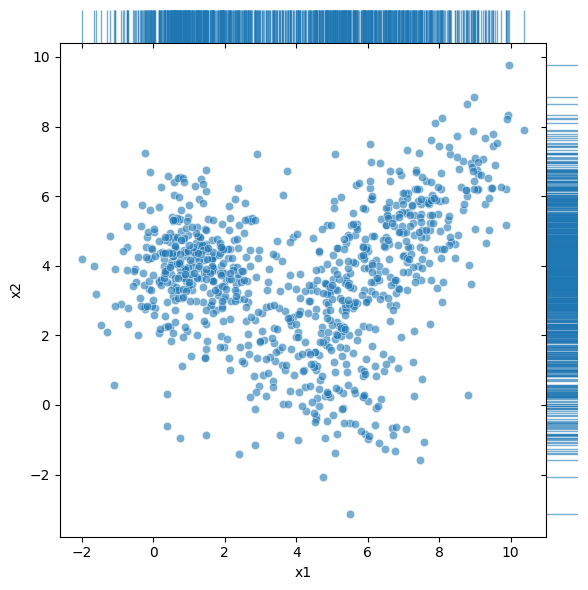

In [3]:
ax = sns.JointGrid(data=training, x="x1", y="x2", space=0, ratio=15);
ax.plot_joint(sns.scatterplot,  alpha=.6, legend=False);
ax.plot_marginals(sns.rugplot, height=1,  alpha=.6);

The ticks (and their density) demonstrate how $x_1$ and $x_2$ distributed. We see that $x_1$ seems to be bimodal whereas $x_2$ seems to be unimodal. Apart from this, there is not that much to tell. Let's get a better view:

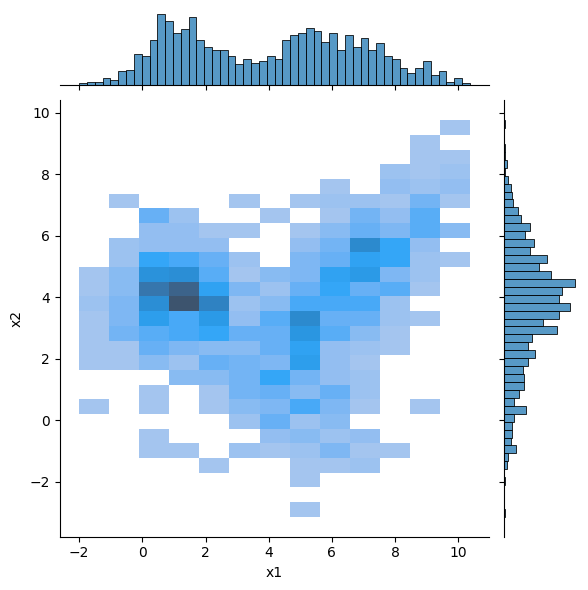

In [4]:
sns.jointplot(data=training, x="x1", y="x2", kind="hist", marginal_kws=dict(bins=50, stat='density'));

Better 👏. Hypothesis from the previous plot confirmed, $x_1$ bimodal and $x_2$ unimodal. More importantly, we can also now see the estimates for marginal distributions $p(x_1)$ and $p(x_2)$ along the both axis. Finally, we can also see the estimates for the joint distribution of both variables through the heatmap. For instance $p(1, 4)$ seems most likely, which makes sense since marginal probabilities $p(x_1 = 1)$ and $p(x_2 = 4)$ are also the highest alone. Alternatively, to smooth things out, we can use `kde` (kernel density estimates):

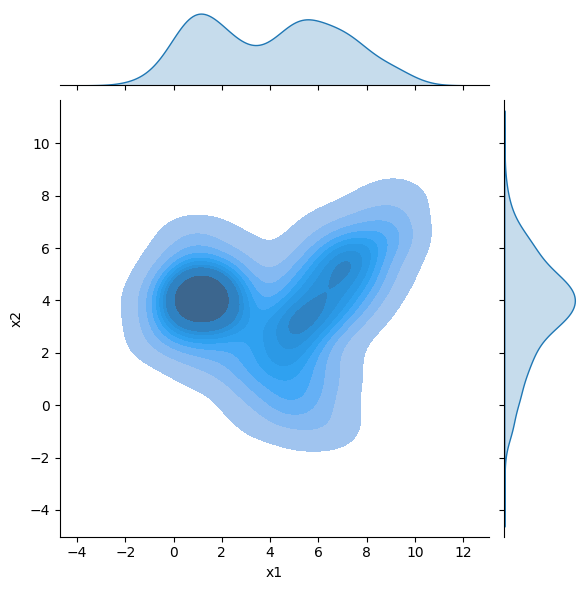

In [5]:
sns.jointplot(data=training, x="x1", y="x2", kind="kde", fill=True);

Hope this makes things at least a bit clearer. 🥳

> Section summary

The main focus of this section was getting up to speed with the fundamentals of probability theory which we will be using throughout this exercise.

### Compensating for class priors

---

> Theory

In the previous exercise, we fitted `KNN10` on the dataset with two features $x_1$ and $x_2$ and $K = 3$ (number of classes). The class distribution in that dataset was even. To keep class distribution even is common thing to do in practice despite the fact that the `true population` might be highly `imbalanced`. The reason for this is simple: `you want your model to learn as much as possible about all classes`.

However, there is one little catch, your model now assumes that the `class priors are same`. Therefore, you have to account for this in your model somehow. Below I describe how for **generative and discriminative** models. (see previous session on the recap on these concepts)

Whether we have trained our model using generative models (`LDA`, `QDA`) or discriminative (`Logistic regression`, `KNN`), we always obtain estimated for the `posterior` probability $P(Y | X)$ which is derived from `Bayes theorem`:

$
P(Y | X) = \frac{P(X | Y)P(Y)}{P(X)}
$

Notice that posterior probability is therefore `proportional` to the `class priors`. (Pause and verify it yourself) Quick side note for those curious how do discriminative models consider class prior. They do so implicitly. I admit this is kind of a vague answer so let me try it better. For instance, predictions of `KNN` directly depend on the class distribution in training data since these if you have a lot of class 1, then chance of classyfying given test point $x$ to this class than to the other classes. In the case of generative models, it is of course explicit - proportion of samples of the given class in the training data.


Back to how to modify fitted class posteriors in order to account for the class distribution of true population. Simply put, we divide the posterior by the training priors and then multiply by the target population:

$
\tilde{P(Y | X)} \propto \frac{P(X | Y)P(Y)}{P(X)}\frac{\tilde{P}(Y)}{P(Y)} = \frac{P(X | Y)\tilde{P}(Y)}{P(X)}
$

This might look familiar (you have seen it in the lecture 7). The 'broken infinity' symbol means that the term on the left `is proportional` to the term on the right, i.e., there exists some constant `c` such that the term on the right can be scaled down/up in order to obtain the term on the left. More specifically, `adjusted posterior probability` is proportional to the class conditionals obtained from the training dataset, class priors based on the true population divided by probability of training input data. Why proportional though, why not equal?

Well, this is because the obtained modified posteriors would not sum to 1. Therefore, we need to also normalize them as follows:

$
\tilde{P(Y | X)} = \frac{P(X | Y)\tilde{P}(Y)}{P(X)}\frac{P(X)}{\tilde{P}(X)} = \frac{P(X | Y)\tilde{P}(Y)}{\tilde{P}(X)}
$

> Practice

So I just showed you how to obtain `adjusted class posteriors`. Let's see how this works in practice, we are given estimated population class priors:

$
\mathrm{P}(Y=y)= \begin{cases}0.0001, & \text { if } y=\text { Black } \\ 0.02, & \text { if } y=\text { Red } \\ 0.979, & \text { if } y=\text { Blue }\end{cases}
$

We need to translate this into code. First, we need to construct our own custom model, i.e., we need to obtain modified class posteriors and then based on these predict the given class, we can build it on top of the sklearn's existing KNN model:

In [6]:
class KNN:

    def __init__(self, K, debug=False):
        # Public
        self.K = K
        self.model = None
        self.debug = debug

        # Private
        self._fitted = False
        self._train_priors = None
    
    def fit(self, X, y):
        # Estimation of class posteriors
        self.model = KNeighborsClassifier(self.K).fit(X, y)

        # Estimation of class priors
        _, counts = np.unique(y, return_counts=True)
        training_n = y.shape[0]
        self._train_priors = counts/training_n

        # Set the fitted flag
        self._fitted = True

        return self
    
    def predict(self, X, pop_priors=None):
        # Assumptions check
        if not self._fitted:
            raise ValueError("KNN has not been fitted yet")
        
        # Initial posteriors
        posteriors = self.model.predict_proba(X) # n x k 2d array
        if self.debug: print("Original posteriors:\n---\n", posteriors)
        
        # Adjust estimated class posteriors
        if pop_priors is not None:

            # Step 1: divide by training priors and multiply by population priors
            unormalized_adjusted_posteriors = (posteriors / self._train_priors)*pop_priors
            if self.debug: print("\nUnnormalized adjusted posteriors:\n---\n", unormalized_adjusted_posteriors)

            # Step 2: normalize
            adjusted_posteriors = unormalized_adjusted_posteriors / unormalized_adjusted_posteriors.sum(axis=1, keepdims=True)
            if self.debug: print("\nAdjusted posteriors:\n---\n", adjusted_posteriors)

            # Step 3: decision function
            return np.argmax(adjusted_posteriors, axis=1)
        
        return np.argmax(posteriors, axis=1)


We can now try it out with and without adjusting the posterior probabilities:

In [7]:
# Fit the model on the balanced training data
knn10 = KNN(10, debug=True).fit(X_train, y_train)

**Without ajusting**, we obtain:

In [8]:
yhat_noadj = knn10.predict(X_test)
yhat_noadj

Original posteriors:
---
 [[0.8 0.2 0. ]
 [1.  0.  0. ]
 [1.  0.  0. ]
 ...
 [0.  0.  1. ]
 [0.  0.  1. ]
 [0.  0.  1. ]]


array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

And **with adjusting**, we obtain:

In [9]:
pop_priors = np.array([1e-4, 2e-2, 0.979])
yhat_adj = knn10.predict(X_test, pop_priors)
yhat_adj

Original posteriors:
---
 [[0.8 0.2 0. ]
 [1.  0.  0. ]
 [1.  0.  0. ]
 ...
 [0.  0.  1. ]
 [0.  0.  1. ]
 [0.  0.  1. ]]

Unnormalized adjusted posteriors:
---
 [[2.400e-04 1.200e-02 0.000e+00]
 [3.000e-04 0.000e+00 0.000e+00]
 [3.000e-04 0.000e+00 0.000e+00]
 ...
 [0.000e+00 0.000e+00 2.937e+00]
 [0.000e+00 0.000e+00 2.937e+00]
 [0.000e+00 0.000e+00 2.937e+00]]

Adjusted posteriors:
---
 [[0.01960784 0.98039216 0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 ...
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]]


array([1, 0, 0, ..., 2, 2, 2], dtype=int64)

Let's compare the class distribution using simple countplots:

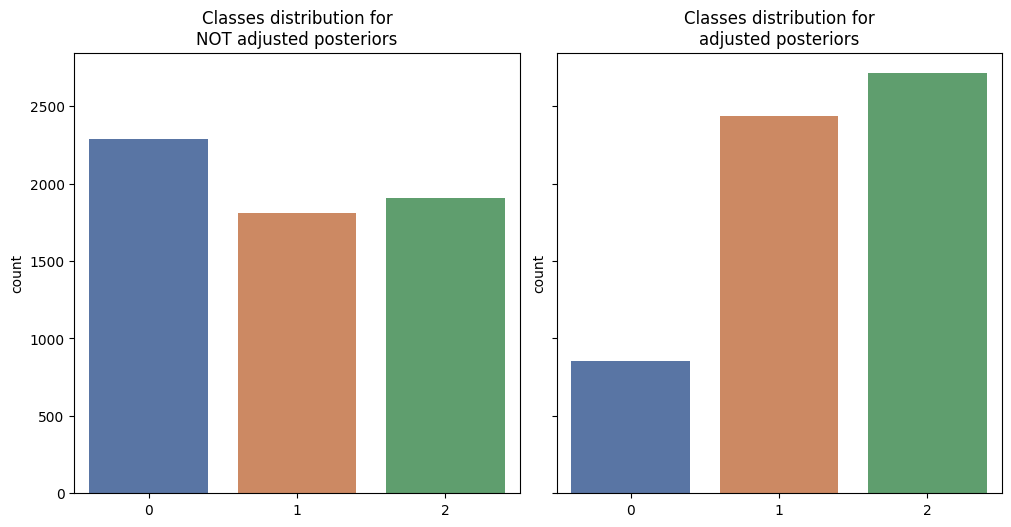

In [10]:
# Figure setup
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True);
plt.tight_layout();

# Unadjusted
sns.countplot(x=yhat_noadj, ax=axs[0], palette="deep");
axs[0].set_title('Classes distribution for\nNOT adjusted posteriors');

# Adjusted
sns.countplot(x=yhat_adj, ax=axs[1], palette="deep");
axs[1].set_title('Classes distribution for\nadjusted posteriors');

Interesting, we see that class 0 no longer dominates after the adjustment. In the same regard, class 2 seems to be more dominant in terms of number of predicted classes which also corresponds to the population priors. Let's also compare the **decision boundaries**:

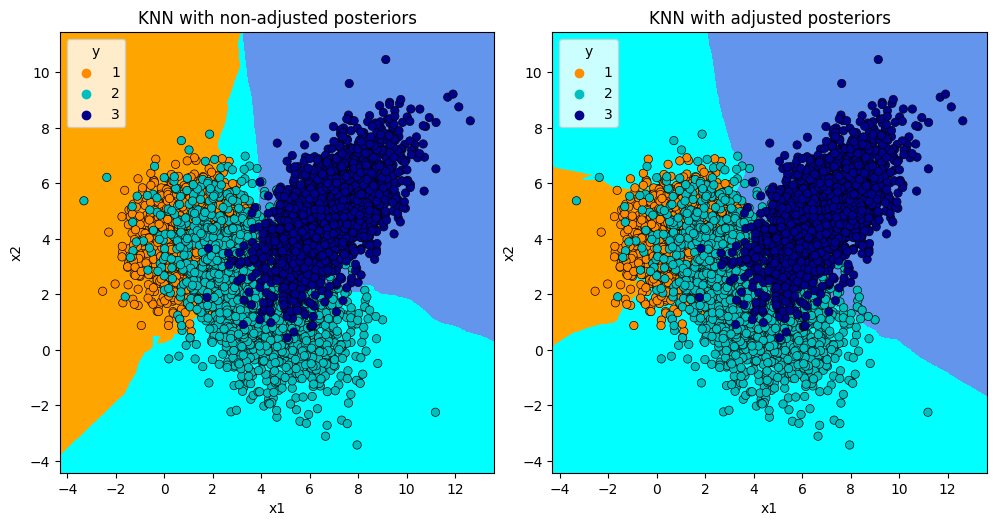

In [11]:
# Define subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5));
plt.tight_layout();

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Define new priors for each subplot
new_priors = [None, pop_priors]

# Mesh step
h = 0.02

# Set debug of the model
knn10.debug = False

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_test["x1"].min() - 1, X_test["x1"].max() + 1
y_min, y_max = X_test["x2"].min() - 1, X_test["x2"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

for i, new_prior in enumerate(new_priors):

    # Plot decision regions
    Z = knn10.predict(np.c_[xx.ravel(), yy.ravel()], new_prior)
    Z = Z.reshape(xx.shape)
    ax[i].contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x="x1", y="x2", hue="y", data=test, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax[i])
    if new_prior is not None:
        ax[i].set_title(f"KNN with adjusted posteriors")
    else:
        ax[i].set_title(f"KNN with non-adjusted posteriors")

Nice, looks pretty interesting and it actually does make sense - we see how the last two classes expanded where as the first class shrank. This corresponds to our findings in the countplot.

> Section summary

In this section, we went into depth of explaining how to modify estimated class priors such that the true population is reflected. This method comes handy in many real world scenarios since usually the class distribution is skewed. Therefore, you resample your training dataset such that it is balanaced, but then you can NOT forget to account for this as described and demonstrated above.

### Playing around with Bayes classifier

---

> Theory

Let's now asssume that we have access to the given population's class condtional and prior probabilities. Note that this is never the case in real life, but here we know it because we just synthetically created the population. Why do we do this you may ask? To get familiar with `Bayes` classifier which is classifier to which we are trying to get as close as possible with our models such as `KNN` etc. 

First, we know the following about class condtional probabilities:

$
p(X \mid Y=1) \sim \mathcal{N}(3,2) \text { and } P(X \mid Y=2) \sim \mathcal{N}(1,4)
$

And about class priors:

$
\mathrm{P}(Y=1)=0.2 \text { and } \mathrm{P}(Y=2)=0.8
$

Bayes classifier uses the above terms to compute the posterior probabilities as follows:

$
P(Y = k | X) = \frac{P(X | Y = k)P(Y=k)}{P(X)}
$

We simply then predict $k$ whose posterior probability is higher under the assumption of 0-1 loss. Notice one interesting thing though, independently ok $k$, we also normalize the numerator by $P(X)$ which is the same for all posterior estimates. Therefore, we could also write the following:

$
P(Y = k | X) \propto P(X | Y = k)P(Y=k) = v_k 
$

We still classify for the highest $v_k$, but we have to be aware we can not really call it probability since it is not normalized. (notice how I use the $\propto$ and $=$ signs)

> Practice

Let's see this in practice:

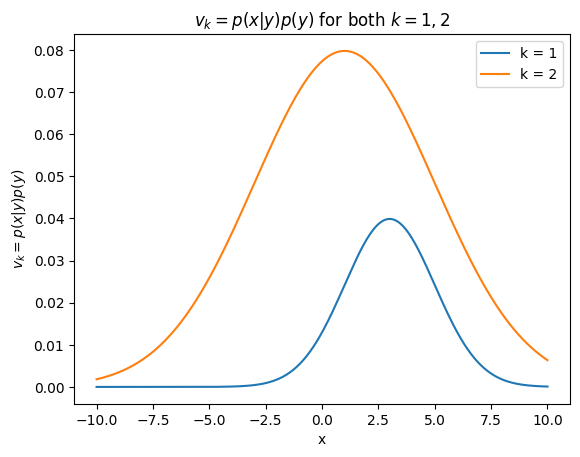

In [12]:
# Define test inputs
start = -10
stop = 10
x = np.linspace(start, stop, int((abs(start) + abs(stop))/0.05))

# Define priors
pc1, pc2 = .2, .8

# Define predictinons that produce v_k for each given x
v1 = norm.pdf(x, 3, 2)*pc1
v2 = norm.pdf(x, 1, 4)*pc2

# Visualize it
fig, ax = plt.subplots();
sns.lineplot(x=x, y=v1, label='k = 1', ax=ax, palette="deep");
sns.lineplot(x=x, y=v2, label='k = 2', ax=ax, palette="deep");
ax.set_ylabel("$v_k = p(x|y)p(y)$");
ax.set_xlabel("x");
ax.set_title("$v_k = p(x|y)p(y)$ for both $k = 1, 2$");

Makes sense given the class conditional probability normal distribution parameters and importantly the class priors. Basically, for any input $x$, we would predict $k = 2$. Let's now try to change the priors:

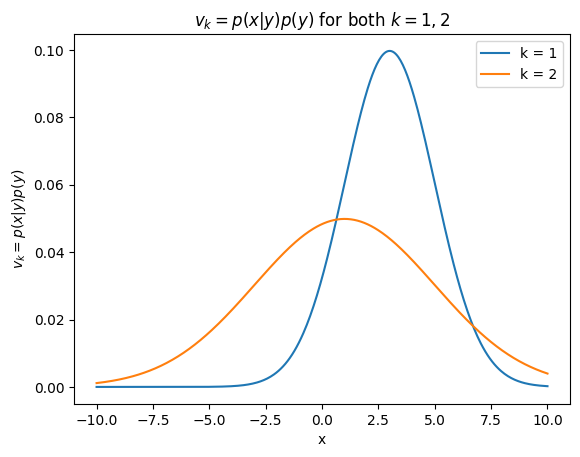

In [13]:
# Define priors
pc1, pc2 = .5, .5

# Define predictinons that produce v_k for each given x
v1 = norm.pdf(x, 3, 2)*pc1
v2 = norm.pdf(x, 1, 4)*pc2

# Visualize it
fig, ax = plt.subplots();
sns.lineplot(x=x, y=v1, label='k = 1', ax=ax, palette="deep");
sns.lineplot(x=x, y=v2, label='k = 2', ax=ax, palette="deep");
ax.set_ylabel("$v_k = p(x|y)p(y)$");
ax.set_xlabel("x");
ax.set_title("$v_k = p(x|y)p(y)$ for both $k = 1, 2$");

We get very different result which is actually more interesting in terms of what predictions we make based on the input. Next, we will normalize the obtained $v_k$ such that we can interpret it as probabilities:

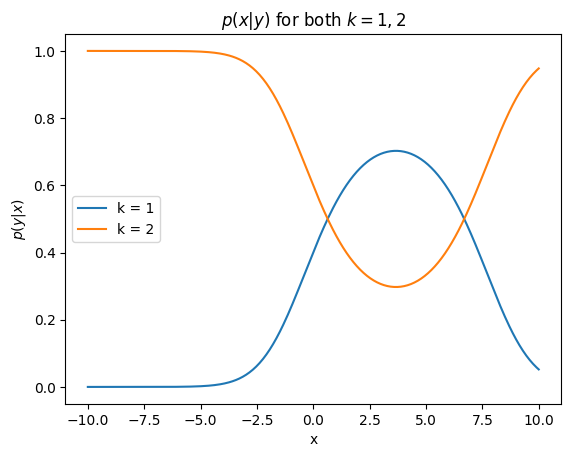

In [14]:
# Define priors
pc1, pc2 = .5, .5

# Define predictions that produce v_k for each given x
v1 = norm.pdf(x, 3, 2)*pc1
v2 = norm.pdf(x, 1, 4)*pc2

# Normalize
total = v1 + v2
posterior1 = v1 / total
posterior2 = v2 / total

# Visualize it
fig, ax = plt.subplots();
sns.lineplot(x=x, y=posterior1, label='k = 1', ax=ax, palette="deep");
sns.lineplot(x=x, y=posterior2, label='k = 2', ax=ax, palette="deep");
ax.set_ylabel("$p(y | x)$");
ax.set_xlabel("x");
ax.set_title("$p(x | y)$ for both $k = 1, 2$");

Finally, we can also compute the irreducible error that comes from the uncertainity:

In [15]:
# p(y = 1 | x) < p(y = 2 | x)
error1 = posterior1[posterior1 < posterior2].sum()

# p(y = 2 | x) < p(y = 1 | x)
error2 = posterior2[posterior2 < posterior1].sum()

# Show the total irreducible error
total_error = error1 + error2
print("Total ireducible error: {:.3f}".format(total_error/posterior1.shape[0]))

Total ireducible error: 0.193


> Section summary

In this section, we got more familiar with Bayes classifier both on theoretical and theoretical level. It is very important to understand that `Bayes` classifier is only a theoretical classifier, i.e., only if we have access to the populations class conditional probabilities and priors, only then we can model the populations posterior probabilities and based on these make the given decision. (under 0-1 loss, predict the class with highest posterior probability) And only then, we can claim that we have got the lowest possible misclassification rate. I know this can be a bit confusing, so do not hesitate to ask me. 😊

### Playing around with loss matrix

---

> Theory

So far, we have assummed that all misclassifications have equal cost. This implied that we chose the class with highest posterior probability. However, in real world setting, this is not neccessary true. Therefore, let's investigate the relationship between our decision based on posterior probability and loss matrix.

We start with creating two variables $l_1$ and $l_2$ which represent contribution to the expected loss based on whether we choose class 1 or class 2:

$
\begin{aligned}
l_1 = L(1, 1)p(x, y=1) + L(2, 1)p(x, y=2) \\
l_2 = L(1, 2)p(x, y=1) + L(2, 2)p(x, y=2)
\end{aligned}
$

Then you want to compute the contribution to the expected loss based on whether your decision $d$ will predict class 1 or class 2. In addition, since joint probability is directly proportional to the posterior probability, we can rewrite the above equtations as follows:

$
\begin{aligned}
l_1 = L(1, 1)p(y=1|x) + L(2, 1)p(y=2|x) \\
l_2 = L(1, 2)p(y=1|x) + L(2, 2)p(y=2|x)
\end{aligned}
$

Naturally, we predict class 1 when $l_1 < l_2$ and vice versa. Assuming that we assign zero to the correct decisions within our loss matrix $L$, then we can expand the above inequation as follows:

$
\begin{aligned}
L(2, 1)p(y=2|x) < L(1, 2)p(y=1|x)
\end{aligned}
$

Since we know that posterior probabilities are complementary, we can adjust the left side:

$
L(2, 1)[1 - p(y=1|x)] < L(1, 2)p(y=1|x)
$

As I mentioned, we are interested in the relation of posterior probability for class 1 with the loss matrix values, therefore, we can rewrite the above inequality as:

$
p(y=1|x) > \frac{L(2, 1)}{L(2, 1) + L(1, 2)}
$

In the denominator, we have the sum of ‘costs’ for making all possible errors. In the numerator, we then have the cost of predicting class 1 instead of the correct class 2. Notice, therefore, that for our 0-1 loss matrix, the right side would be 0.5. Similar logic can then be extended to arbitrary number of classes. So far instance, if our loss matrix looks as follows:

$
L=\left[\begin{array}{cc}
0 & 1000 \\
1 & 0
\end{array}\right]
$

Then, our decision function would be defined as follows:

$
p(y=1|x) > \frac{L(2, 1)}{L(2, 1) + L(1, 2)} = \frac{1}{1001} \approx .0009
$

Similarly, for the class 2 we get:

$
p(y=2|x) > \frac{1000}{1001} \approx 0.99
$

This means that we have to be pretty sure if we want to predict class 2.

> Section summary

This section was rather theoretical, but allowed us to explore more in depth the relation between the loss matrix $L$ and the decision function.

### Estimating class conditinals and priors from sample

---

> Theory

In practice, you do not know what are the true class priors and conditional probabilities. You have to estimate it based on the provided training dataset. 

For the class priors, you have been shown in the lecture that the best way to estimate them is to use the proportion of class samples out of the total training size. This was derived from the maximum likelihood estimation. Fairly easy.

But how about the class conditionals, for these, there are many different ways. You have learnt about `LDA` and `QDA` which both take a different approach. In the below practical example, I will use a way which is practically similar to the `LDA`, i.e., we assume that the class conditional come from the normal distribution and we need to estimate the mean $\mu$ and variance $\sigma^2$. In LDA, you usually have a multivariate input $x$, therefore you estimate a vector $\mu$ where for each class and feature you have a separate mean estimate. Instead of variance you estimate covariance matrix which is assumed to be same for all classes. We will talk about this next session.

> Practice

First, we need to obtain the training dataset. We need to sample from the generative model in the section about `Bayes classifier`. Assuming that class priors are equal, i.e., $0.5$ we simply first generate for which class we sample and then use the corresponding class conditional distribution:

In [16]:
# Define size of training
N = 1000

# Save the sampled data to these
x = []
y = []

for _ in range(N):
    p = np.random.random()
    if p < .5:
        p = np.random.random()
        x.append(norm.ppf(p, 3, 2))
        y.append(1)
    else:
        p = np.random.random()
        x.append(norm.ppf(p, 1, 4))
        y.append(2)

Now, that we have generated the data training data, we can estimate the needed parameters for the class priors and conditionals:

In [17]:
# Priors
_, counts = np.unique(y, return_counts=True)
prior1, prior2 =  counts / len(y)
print("Prior k = 1: {:.3f}".format(prior1), "Prior k = 2: {:.3f}".format(prior2))

# Conditionals class mean and variance
xarr, yarr = np.array(x), np.array(y)
mean1, mean2 = xarr[yarr == 1].mean(), xarr[yarr == 2].mean()
print("Mean 1: {:.3f} | Mean 2: {:.3f}".format(mean1, mean2))
std1, std2 = xarr[yarr == 1].std(), xarr[yarr == 2].std()
print("Std 1: {:.3f} | Std 2: {:.3f}".format(std1, std2))

Prior k = 1: 0.491 Prior k = 2: 0.509
Mean 1: 2.947 | Mean 2: 1.171
Std 1: 2.029 | Std 2: 3.942


These parameters makes sense given the original distrubition parameters. Let's now test out how our model works on new test data:

In [18]:
# -- Generate the test data
# Define size of test
N = 200

# Save the sampled data to these
x = []
y = []

for _ in range(N):
    p = np.random.random()
    if p < .5:
        p = np.random.random()
        x.append(norm.ppf(p, 3, 2))
        y.append(0)
    else:
        p = np.random.random()
        x.append(norm.ppf(p, 1, 4))
        y.append(1)

# -- Make prediction on these:
# Define predictions that produce v_k for each given x
v1 = norm.pdf(x, mean1, std1)*prior1
v2 = norm.pdf(x, mean2, std2)*prior2

# Normalize
total = v1 + v2
posterior1 = v1 / total
posterior2 = v2 / total

# Make the actual prediction
yhat = np.argmax(np.column_stack((posterior1, posterior2)), axis=1)

Finally, we can compute the confusion matrix how our model is doing:

In [19]:
confusion_matrix(y, yhat)

array([[76, 17],
       [39, 68]], dtype=int64)

We see that it is not doing that bad considering the training procedure. Most often, it predicts class 1 instead of class 2.

> Section summary

In this section, we learnt how we can sample from a generative model. In addition, we created a new generative model using parameters estimated from the sampled training data. This is it for this week and this session! Have I header Friday bar? 🍻

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71ce8a7f-1815-46b1-bbeb-2be3f29e2449' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>